In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns

2023-04-17 15:27:05.013832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 15:27:05.130889: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 15:27:05.134117: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/venv/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-17 15:27:05.134133:

In [35]:
def extract_patches(image_path, stride, patch_height=100, patch_width=100):
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    clahe = cv2.createCLAHE(clipLimit =10.0, tileGridSize=(8,8)) # Parameters used in original paper
    img = clahe.apply(img)/255.0


    # Convert the image to a tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0) #batch
    img_tensor = tf.expand_dims(img_tensor, axis=-1) #channel

    patches = tf.image.extract_patches(images=img_tensor,
                                        sizes=[1, patch_height, patch_width, 1],
                                        strides=[1, stride, stride, 1],
                                        rates=[1, 1, 1, 1],
                                        padding='VALID')


    return patches


In [3]:
def get_patch_coordinates( column_idx, row_idx, stride, patch_height, patch_width):
    x = column_idx * stride
    y = row_idx * stride
    x_max = x + patch_width
    y_max = y + patch_height
    return (y, x, y_max, x_max)


In [4]:
def plot_patch(patches_tensor, column_idx, row_idx, stride, patch_height, patch_width):
    patch = patches_tensor[0,column_idx,row_idx,:]
    patch_image = tf.reshape(patch, [patch_height, patch_width])
    plt.imshow(patch_image, cmap='gray')
    coordinates = get_patch_coordinates( column_idx, row_idx, stride, patch_height, patch_width)
    # print(coordinates)
    return coordinates


In [5]:
def plot_bounding_box(image_path, coordinates):
    img = cv2.imread(image_path)
    img_copy = img.copy()
    y, x, y_max, x_max = coordinates
    cv2.rectangle(img_copy, (y, x), (y_max, x_max), (0, 255, 0), 2)
    plt.imshow(img_copy)


In [32]:
img_path = '/work/79b4uL-3635705857.jpg'

2023-04-17 15:27:07.373848: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/venv/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-17 15:27:07.373877: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-17 15:27:07.373893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-8f63fdc3-7b28-4cc7-8735-09f23d070fd3): /proc/driver/nvidia/version does not exist
2023-04-17 15:27:07.374175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild

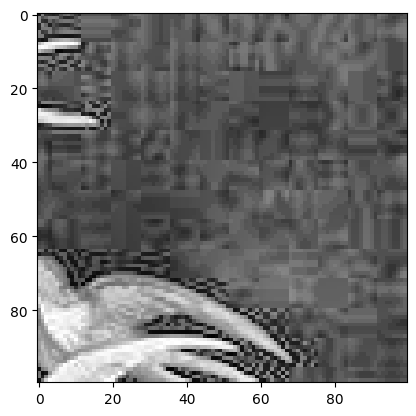

In [7]:
patches = extract_patches(img_path,100,100,100)
print(patches.shape)
coordinates = plot_patch(patches, 2,1, 100,100,100)
print(coordinates)

In [8]:
# patch = patches[0,9,12,:]
# patch_image = tf.reshape(patch, (1, 100, 100, 1))
# model.predict(patch_image)

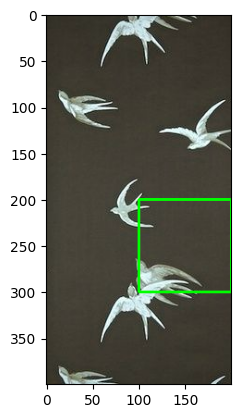

In [9]:
plot_bounding_box(img_path, coordinates)

In [36]:
def prediction_matrix(model, image_path, stride, patch_height=100, patch_width=100):
    img_height, img_width = cv2.imread(image_path).shape[:2]
    prediction_matrix = np.zeros((img_height, img_width))
    count_matrix = np.zeros((img_height, img_width))

    patches = extract_patches(image_path, stride, patch_height=100, patch_width=100)
    print(patches.shape)
    for column_idx in range(patches.shape[1]):
        for row_idx in range(patches.shape[2]):
            print(column_idx, row_idx)
            y, x, y_max, x_max = get_patch_coordinates(row_idx, column_idx, stride, patch_height, patch_width) # y,x, y_max, x_max
            print(y, x, y_max, x_max)
            patch = patches[0,column_idx,row_idx,:]
            patch_image = tf.reshape(patch, (1, patch_height, patch_width, 1))
            prediction = model.predict(patch_image, verbose = 0)
            prediction_matrix[y:y_max, x:x_max] += prediction
            count_matrix[y:y_max, x:x_max] += 1
    
    # result = prediction_matrix / count_matrix

    return prediction_matrix, count_matrix

In [11]:
model = tf.keras.models.load_model('/work/Cavity_detection/models/DCNN3/best_model.h5')
img_path = '/work/Cavity_detection/data/interim/caries/Image_584_RODRIGUEZ-MORENO-MARTHA-CECILIA_Intraoral_JPG.rf.31b5f660874bb6e27301bbde7243fa3a.jpg'

In [37]:
prediction, count = prediction_matrix(model, img_path, stride=100, patch_height=100, patch_width=100)

(1, 4, 2, 10000)
0 0
0 0 100 100
0 1
0 100 100 200
1 0
100 0 200 100
1 1
100 100 200 200
2 0
200 0 300 100
2 1
200 100 300 200
3 0
300 0 400 100
3 1
300 100 400 200


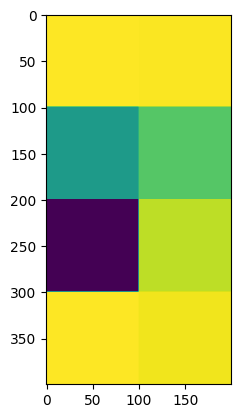

In [38]:
plt.imshow(prediction)

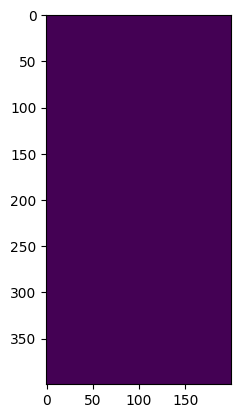

In [39]:
plt.imshow(count)


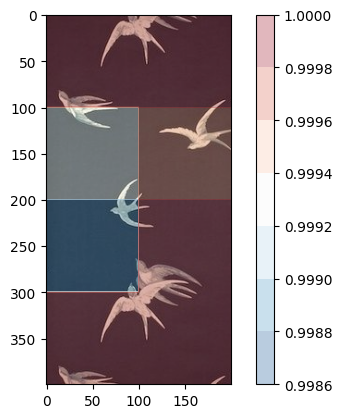

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image

# Load image and get x and y extents
img = Image.open(img_path)
w, h = img.size
y, x = np.mgrid[0:h, 0:w]

matrix = prediction/count
# Create colormap with transparency when near zero
# mycmap = mcolors.LinearSegmentedColormap.from_list('mycmap', [(0, 'rgba(0,0,0,0)'), (0.25, 'blue'), (1, 'red')])

# Plot image and overlay heatmap
fig, ax = plt.subplots()
ax.imshow(img)
heatmap = ax.contourf(x, y, matrix, alpha=0.3, cmap = 'RdBu_r')
plt.colorbar(heatmap)

plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f63fdc3-7b28-4cc7-8735-09f23d070fd3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>